In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from utils import * 
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [85]:
data = read_abilene_data(read_week = True, week = 1)
data = data/1e7

#### FFT of Time Series Signal -- to do

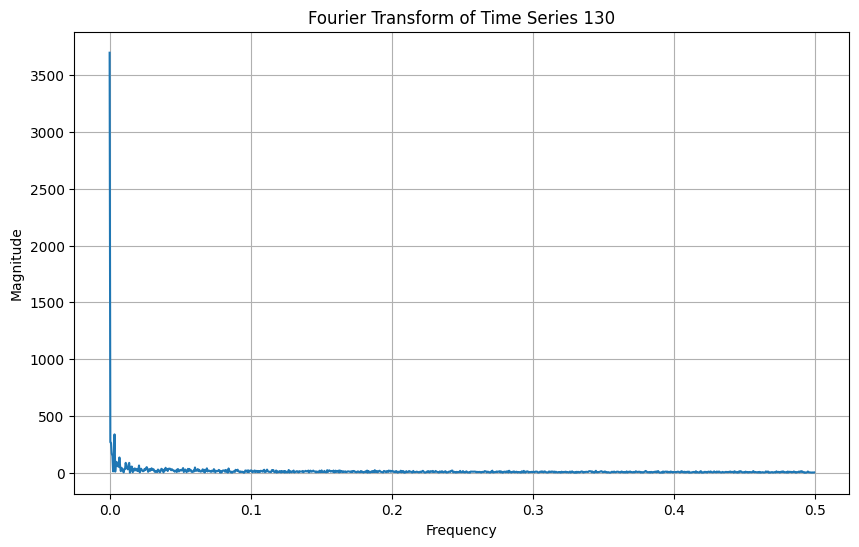

In [86]:
time_series_data = data

# Sampling frequency (assume uniform sampling, 1 sample per time unit)
fs = 1  # Adjust if your data has a different sampling rate

# Fourier Transform of the time series data
frequencies = np.fft.fftfreq(time_series_data.shape[0], d=1/fs)  # Frequency bins
fft_magnitudes = np.abs(np.fft.fft(time_series_data, axis=0))  # Compute FFT along time axis

# Plot the Fourier Transform of the first time series as an example
time_series_index = 130  # Choose the index of the time series to visualize

plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], fft_magnitudes[:len(frequencies)//2, time_series_index])
plt.title(f"Fourier Transform of Time Series {time_series_index}")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


## Denoising Data

#### Moving Average Smoothing

In [95]:
window_size = 15

# Convert data to a pandas DataFrame for convenience
time_series_df = pd.DataFrame(data)

# Apply rolling mean to all columns
smoothed_df = time_series_df.rolling(window=window_size, min_periods=1).mean()

# Convert back to NumPy array if needed
moving_avg = smoothed_df.values


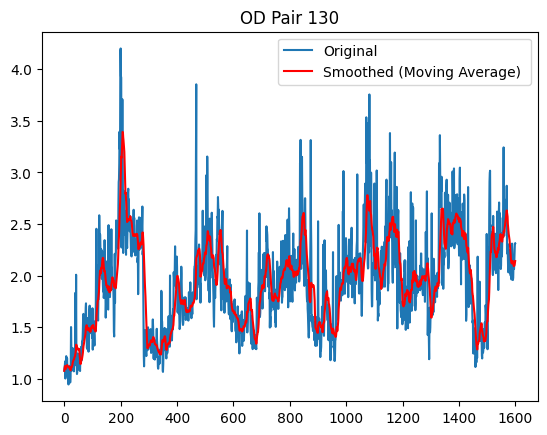

In [96]:
# Plot an example time series before and after smoothing
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(moving_avg[:1600, series_index], label="Smoothed (Moving Average) ", color='red')
plt.title('OD Pair %d' % series_index)
plt.legend()
plt.show()

#### Exponential Moving Average Smoothing

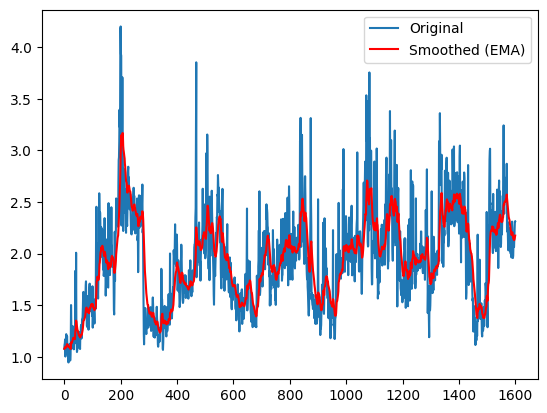

In [97]:
alpha = 0.1  # Smoothing factor
# Convert data to a pandas DataFrame
time_series_df = pd.DataFrame(data)

# Apply EMA to all columns at once
ema_df = time_series_df.ewm(alpha=alpha, adjust=False).mean()

# Convert back to NumPy array if needed
exp_ma = ema_df.values

series_index = 130  # Choose a time series to visualize
# Plot
plt.plot(data[:1600, series_index], label="Original")
plt.plot(exp_ma[:1600, series_index], label="Smoothed (EMA)", color='red')
plt.legend()
plt.show()

#### Low Pass Filter

Original Data Shape: (2016, 144)
Low Pass Filter Data Shape: (2016, 144)


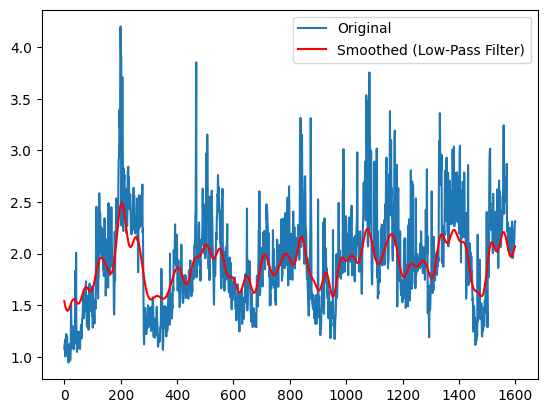

In [98]:
# Fourier Transform

# Low-pass filter implementation
def low_pass_filter(signal, cutoff_frequency):

    # Perform Fourier Transform
    freq_data = np.fft.fft(signal)
    
    # Zero out high-frequency components
    freq_data[cutoff_frequency:] = 0
    freq_data[-cutoff_frequency:] = 0  # Mirror for negative frequencies
    
    # Inverse Fourier Transform to get back to time domain
    filtered_signal = np.fft.ifft(freq_data).real
    return filtered_signal

# Apply low-pass filter to all time series
cutoff_frequency = 50  # Choose an appropriate cutoff frequency
lp_filt_data = np.zeros_like(data)

for i in range(data.shape[1]):  # Iterate over each time series
    lp_filt_data[:, i] = low_pass_filter(data[:, i], cutoff_frequency)

# Check results
print("Original Data Shape:", data.shape)
print("Low Pass Filter Data Shape:", lp_filt_data.shape)

# Plot an example time series before and after filtering
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(lp_filt_data[:1600, series_index], label="Smoothed (Low-Pass Filter)", color='red')
plt.legend()
plt.show()


Original Data Shape: (2016, 144)
Smoothed Data Shape: (2016, 144)


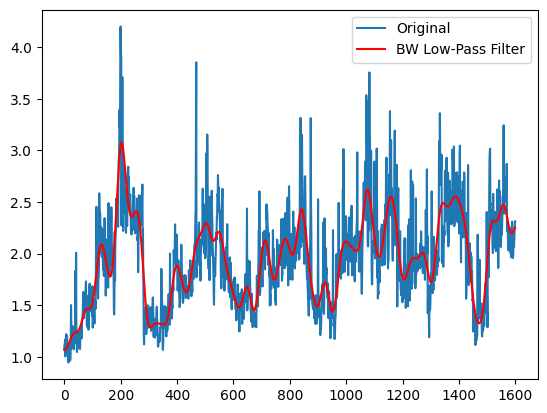

In [99]:
from scipy.signal import butter, filtfilt

# Butterworth filter design
def butter_lowpass_filter(data, cutoff, fs, order=4):
    
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply Butterworth low-pass filter to all time series
cutoff = 0.02  # Cutoff frequency (Hz)
sampling_frequency = 1.0  # Assuming 1 sample per unit time
bw_lp_filt_data = np.zeros_like(time_series_data)

for i in range(time_series_data.shape[1]):  # Iterate over each time series
    bw_lp_filt_data[:, i] = butter_lowpass_filter(time_series_data[:, i], cutoff, sampling_frequency)

# Check results
print("Original Data Shape:", time_series_data.shape)
print("Smoothed Data Shape:", bw_lp_filt_data.shape)

# Plot an example time series before and after filtering
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(bw_lp_filt_data[:1600, series_index], label="BW Low-Pass Filter", color='red')
plt.legend()
plt.show()

#### Savgol Filter

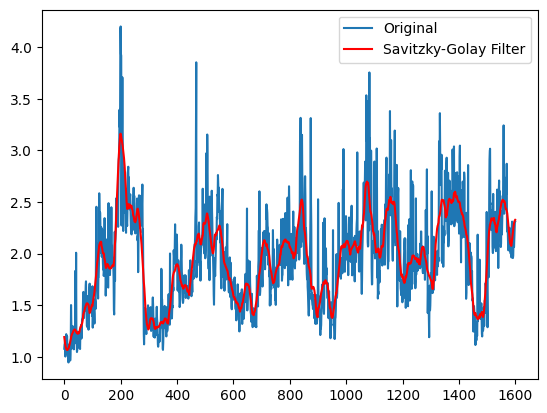

In [100]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
sg_filt_data = savgol_filter(data, window_length=50, polyorder=3, axis = 0)

# Plot
series_index = 130
plt.plot(data[:1600, series_index], label="Original")
plt.plot(sg_filt_data[:1600, series_index], label="Savitzky-Golay Filter", color='red')
plt.legend()
plt.show()


#### Wavelet-- to do

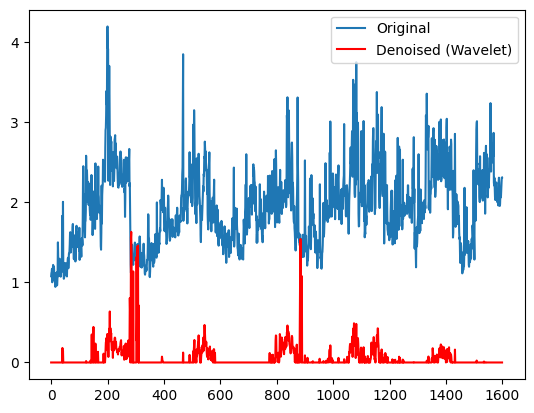

In [103]:
import pywt
import pywt.data

# Wavelet transform for denoising
coeffs = pywt.wavedec(data, 'db1', level=4)  # Decompose
threshold = np.sqrt(2 * np.log(len(data)))   # Universal threshold
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]  # Thresholding
wavelet_data = pywt.waverec(coeffs, 'db1')  # Reconstruct

# Plot
series_index = 130
plt.plot(data[:1600, series_index], label="Original")
plt.plot(wavelet_data[:1600, series_index], label="Denoised (Wavelet)", color='red')
plt.legend()
plt.show()


## Statistics of Denoised Data

### Correlation -- Moving Average

#### (S,D) pairs sharing the same source

In [28]:
from scipy.stats import pearsonr
import itertools as it

# Feature-wise min-max normalization (normalize each element over time)
traffic_matrices=smoothed_data.reshape(-1, 12, 12)
min_vals = traffic_matrices.min(axis=0)  # Shape (12, 12)
max_vals = traffic_matrices.max(axis=0)  # Shape (12, 12)
normalized_matrices = (traffic_matrices - min_vals) / (max_vals - min_vals + 1e-8)  # Avoid division by zero

# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
source_correlations = {}
pairs_1 = it.product()
for (s, d) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (s_1, d_1) in source_dests_2: 
        # if sources are equal
        if (s_1 == s):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    source_correlations[(s, d)] = correlations

In [29]:
# Remove duplicates from list for computing CDF and PDF of correlations
sources = list(range(12))
source_correlations_final = {}
for source in sources: 
    filtered_keys = [key for key in source_correlations.keys() if key[0] == source]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = source_correlations[filtered_key]

        for s, d, corr in temp1:
            if (s,d) not in used_keys:
                corr_list.append(corr)
            else: 
                continue


        used_keys.append(filtered_key)

    source_correlations_final[source] = corr_list

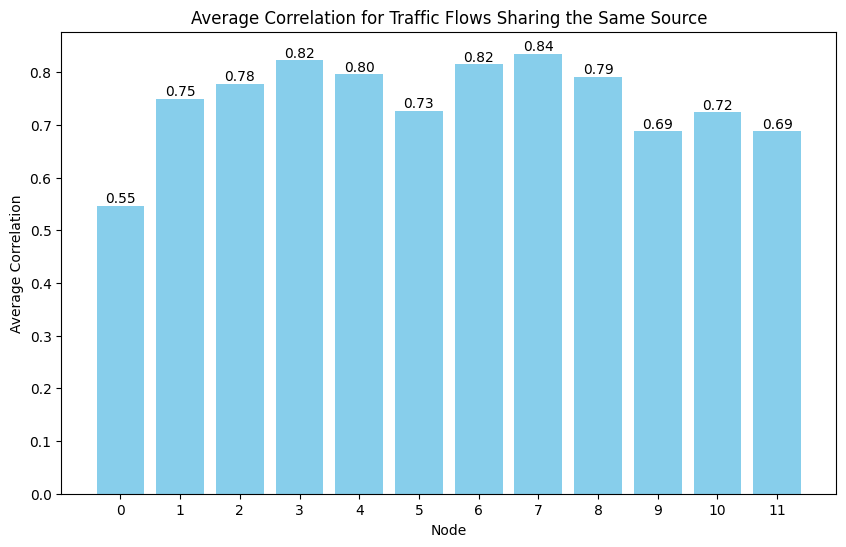

In [34]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(source_correlations_final[source]) for source in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing the Same Source')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
plt.savefig('Figs/smoothed_data/avg_correlation_same_source_ma.png', dpi = 300)
plt.show()

#### (S,D) pairs sharing the same destination

In [31]:
# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
destination_correlations = {}

for (d, s) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (d_1, s_1) in source_dests_2: 
        # if destinations are equal
        if (d_1 == d):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    destination_correlations[(d, s)] = correlations

In [32]:
# Remove duplicates from list for computing CDF and PDF of correlations
destinations = list(range(12))
dest_correlations_final = {}
for dest in destinations: 
    filtered_keys = [key for key in destination_correlations.keys() if key[0] == dest]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = destination_correlations[filtered_key]

        for d, s, corr in temp1:
            if (d,s) not in used_keys:
                corr_list.append(corr)
            else: 
                continue


        used_keys.append(filtered_key)

    dest_correlations_final[dest] = corr_list

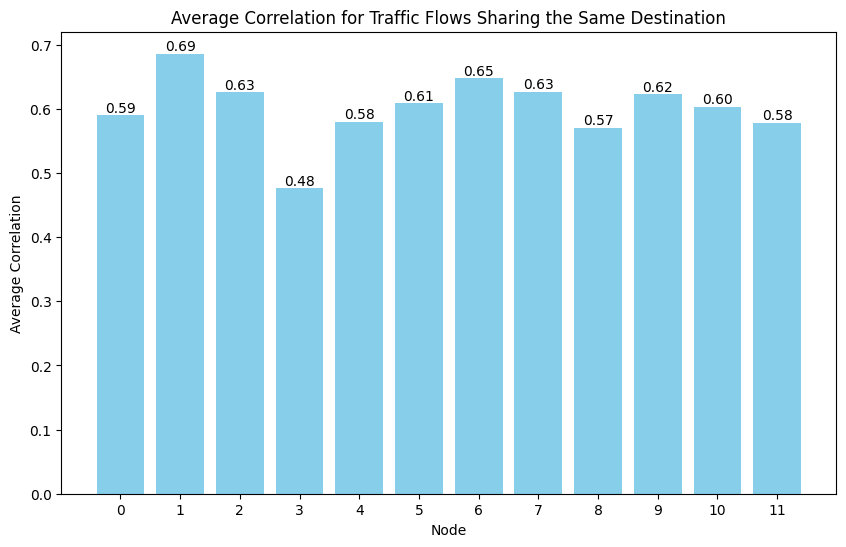

In [35]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(dest_correlations_final[dest]) for dest in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing the Same Destination')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
plt.savefig('Figs/smoothed_data/avg_correlation_same_dest_ma.png', dpi = 300)
plt.show()

#### (S,D) Pairs Sharing No Source or Destinations

In [36]:
# Create combinations
source_dests = list(it.product(range(0,12), repeat = 2))
source_dests_2 = source_dests
source_dest_pairs = list(it.combinations_with_replacement(source_dests, 2))

# Compute Pearson correlation for each source over time
no_common_correlations = {}

for (s, d) in source_dests:
    correlations = []

    # Get the time series for the (source, dest) pair
    ts_1= normalized_matrices[:, s, d]

    for (s_1, d_1) in source_dests_2: 
        # if destinations are equal
        if (d_1 != d) & (d_1 != s) & (s_1 != s) & (s_1 != d):
            # Get the time series for the (source, dest) pair
            ts_2= normalized_matrices[:, s_1, d_1]

            # Calculate Pearson correlation for this source with all other destinations
            # Append correlations in the form (dest, correlation_value)
            correlation, _ = pearsonr(ts_1, ts_2)
            correlations.append((s_1, d_1, correlation))
    
    # Store correlations for the current source
    no_common_correlations[(s, d)] = correlations

In [37]:
# Remove duplicates from list for computing CDF and PDF of correlations
sources = list(range(0,12))
no_common_correlations_final = {}

for source in sources: 
    filtered_keys = [key for key in no_common_correlations.keys() if key[0] == source]

    used_keys = []
    corr_list = []
    for filtered_key in filtered_keys: 
        temp1 = no_common_correlations[filtered_key]

        for s, d, corr in temp1:
            corr_list.append(corr)

    no_common_correlations_final[source] = corr_list

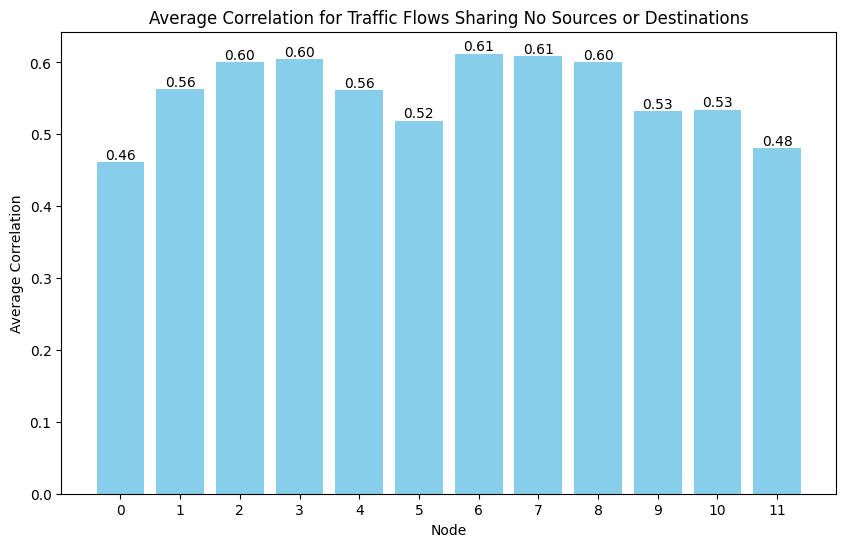

In [38]:
# Calculate the average correlation for each of the 12 lists
average_correlations = [np.mean(np.abs(no_common_correlations_final[dest])) for dest in range(0,12)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 12), average_correlations, color='skyblue')
plt.bar_label(bars,  fmt='%.2f')
plt.title('Average Correlation for Traffic Flows Sharing No Sources or Destinations')
plt.xlabel('Node')
plt.ylabel('Average Correlation')
plt.xticks(range(0, 12))  # Label x-axis from 1 to 12
plt.savefig('Figs/smoothed_data/avg_correlation_no_source_dest_ma.png', dpi = 300)
plt.show()

Correlation does not change significantly from noisy data for sharing same source or destination. However, the correlation is changed for (S,D) pairs sharing no source or destination

## TM Prediction for Denoising Data

Create a dictionary of different denoised data values. Then use a for loop to streamline the prediction process and loop through each variable.

In [104]:
denoised_dict = {'moving_average': moving_avg, 'exp_moving_avg': exp_ma, 
                 'low_pass_filt': lp_filt_data, 'bw_filt': bw_lp_filt_data, 'savgol': sg_filt_data}

# Parameters for plotting
dgreen = [0.05, 0.5, 0.05]  # RGB color for green
dgrey = [0.65, 0.65, 0.65]  # RGB color for grey
dred = [0.8, 0.1, 0.1] # RGB color for red
fontsize = 18

In [ ]:
for method, denoised_data in denoised_dict.items():
    print(f'###### training for denoising method: {method} ######\n')
    # train, test split
    train_data, test_data = train_test_split(denoised_data, 0.8)
    window = 10

    # Min Max Normalize the train data and test data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_norm = normalize_matrix(scaler, train_data)

    scaler = MinMaxScaler(feature_range=(0,1))
    test_data_norm = normalize_matrix(scaler, test_data)

    # Window the dataset 
    trainX, trainY= create_dataset(train_data_norm, window) 
    testX, testY = create_dataset(test_data_norm, window) 

    # Define hyperparameters
    num_nodes = 12 
    input_size = trainX.shape[2] # Number of features in input
    hidden_size = 200  # Number of features in hidden state
    learn_rate = 0.001 
    epochs = 100
    num_layers = 1
    batch_size = 32
    shuffle = False #don't want to lose the time dependency
    num_workers = 4  # Number of subprocesses to use for data loading

    # Create training dataset and dataloader
    train_loader = get_dataloader(trainX, trainY, batch_size, num_workers, shuffle)
    test_loader = get_dataloader(testX, testY, 1, num_workers, shuffle)

    # Train RNN 
    # Create Model 
    model = RNN(input_size, hidden_size, num_layers)

    # Create optimizer 
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    # Create loss function
    criterion = nn.MSELoss()

    # Train the model
    loss = train(model, train_loader, epochs, criterion, optimizer)

    # Test model
    model_outputs, _ = test(model, criterion, test_loader, testY)

    # Save the model 
    PATH = f'models\\abilene_global_mse_{method}.pth'
    torch.save(model.state_dict(), PATH)

    # Save the model_outputs
    np.save(f'model_outputs\\abilene_global_mse_{method}.npy', 
            model_outputs)
    
    # Plot heat maps 
    plot_and_save_heatmap(test_data_norm, model_outputs, num_nodes, save_path = 'Figs\\heat_maps', 
                        fig_name = f'normalized_model_predictions_{method}.png')
    
    inverse_preds = inverse_normalize_predictions(test_data, model_outputs) 
    plot_and_save_heatmap(test_data, inverse_preds, num_nodes, save_path = 'Figs\\heat_maps',
                          fig_name= f'inverse_normalized_model_predictions_{method}.png')
    
    # Compute difference
    difference = inverse_preds - denoised_data[len(train_data):-10]
    plot_and_save_diffmap(difference, num_nodes, save_path = 'Figs\\heat_maps', fig_name = f'difference_heatmap_{method}.png')

    # Plot difference 
    fig, ax = plt.subplots(figsize = (7,6))
    pair = 130
    ax.plot(difference[:, pair], label = 'Difference', color = dred)
    ax.plot(inverse_preds[:, pair], label = 'Prediction', color = dgreen)
    ax.plot(denoised_data[len(train_data):-10], label = 'Ground Truth', color = dgrey)
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Difference = Prediction - Ground Truth')
    ax.set_title(f'Difference of Prediction vs. Ground Truth Denoised Data for {method}')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'Figs\\difference_plot_{method}.png', dpi = 300)
    plt.close()

    # Run MLU
    # Compute MCF on inverse normalized predictions
    mlu_preds, Nans = mlu_on_preds(inverse_preds)

    if Nans: 
        print('NaN values in mlu_preds, ending program')
        continue
    
    # Save MLUs
    np.save(f'model_outputs\\mlu_preds_abilene_global_mse_{method}.npy', mlu_preds)

    # Load MCF baseline on original dataset (not denoised)
    mlu_gt = np.load('mlu_baseline\\mlu_baseline_abilene.npy')
    mlu_gt = mlu_gt[len(train_data):]
    
    # Plot mlu cdf and mlu comparison
    plot_and_save_ecdf(mlu_gt, mlu_preds, save_path = 'Figs\\ecdfs', 
                       fig_name=f'CDF_mlu_abilene_global_mse_{method}.png', title = f'CDF of MLU - Predictions via {method}')
    plot_and_save_mlu_compare(mlu_gt, mlu_preds, save_path='Figs\\mlu_compare', 
                              fig_name=f'mlu_compare_abilene_global_mse_{method}.png', title = f'MLU - Predictions via {method} vs. Ground Truth')
    plot_and_save_pdf(mlu_gt, mlu_preds, save_path = 'Figs\\pdfs', 
                      fig_name=f'PDF_mlu_abilene_global_mse_{method}.png', title = f'PDF of MLU - Predictions via {method}')


###### training for denoising method: moving_average ######

-----Begin Training------
